# Agent Based Models

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 9

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [23]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='jshtml')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Schelling's model

In [24]:
from Cell2D import Cell2D, Cell2DViewer

`locs_where` is a wrapper on `np.where` that returns results in an array (rather than two tuples).

In [25]:
def locs_where(condition):
    """Find cells where a logical array is True.
    
    Transposing the results from np.nonzero yields
    an array with one set of coordinates per row.
    
    condition: logical array
    
    returns: array with one set of coordinates per row
    """
    return np.transpose(np.nonzero(condition))

Here's my implementation of Schelling's model:

In [26]:
from scipy.signal import correlate2d

class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, m=None, p=0.5):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: threshold on the fraction of similar neighbors
        """
        self.p = p
        m = n if m is None else m
        # 0 is empty, 1 is red, 2 is blue, 3 is green
        choices = [0, 1, 2, 3]
        probs = [0.1, 0.9/3, 0.9/3, 0.9/3]
        self.array = np.random.choice(choices, (n, m), p=probs).astype(np.int8)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        green = a==3

        # count red neighbors, blue neighbors, and total
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_green = correlate2d(green, self.kernel, **self.options)
        num_neighbors = num_red + num_blue + num_green

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors
        frac_green = num_green / num_neighbors
        
        # no neighbors is considered the same as no similar neighbors 
        # (this is an arbitrary choice for a rare event)
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0
        frac_green[num_neighbors == 0] = 0

        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, np.where(blue, frac_blue, frac_green))

        # for empty cells, frac_same is NaN
        frac_same[empty] = np.nan
        
        return empty, frac_red, frac_blue, frac_green, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells
        unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)

        # find the empty cells
        num_empty = np.sum(empty)
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        for source in unhappy_locs:
            i = np.random.randint(len(empty_locs))
            dest = tuple(empty_locs[i])

            # move
            a[dest] = a[tuple(source)]
            a[tuple(source)] = 0
            empty_locs[i] = source
        
        # check that the number of empty cells is unchanged
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)

`make_cmap` makes a custom color map.

In [27]:
from matplotlib.colors import LinearSegmentedColormap

def make_cmap(color_dict, vmax=None, name='mycmap'):
    """Makes a custom color map.
    
    color_dict: map from numbers to colors
    vmax: high end of the range, 
    name: string name for map
    
    If vmax is None, uses the max value from color_dict
    
    returns: pyplot color map
    """
    if vmax is None:
        vmax = max(color_dict.keys())
    
    colors = [(value/vmax, color) for value, color in color_dict.items()]
    
    cmap = LinearSegmentedColormap.from_list(name, colors)
    
    return cmap

A `SchellingViewer` is a basic `Cell2DViewer`

In [28]:
class SchellingViewer(Cell2DViewer):
    # colors from http://colorbrewer2.org/#type=qualitative&scheme=Accent&n=5
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
    cmap = make_cmap({0:'white', 1:colors[2], 2:colors[4], 3:'green'})
    options = dict(interpolation='none', alpha=0.8)

Here's a small example.

0.3634733893557423

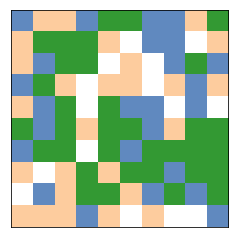

In [29]:
grid = Schelling(n=10)
viewer = SchellingViewer(grid)
viewer.draw()
grid.segregation()

And here's an animation for a bigger example:

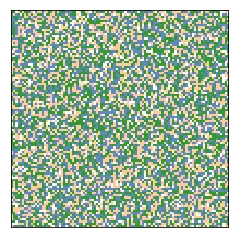

In [30]:
grid = Schelling(n=100)
viewer = SchellingViewer(grid)
anim = viewer.animate(frames=30)

The degree of segregation increases quickly.

In [31]:
anim

The following figure shows the process after 2 and 10 steps.

0.335956780308
0.516193735954
0.726087382861


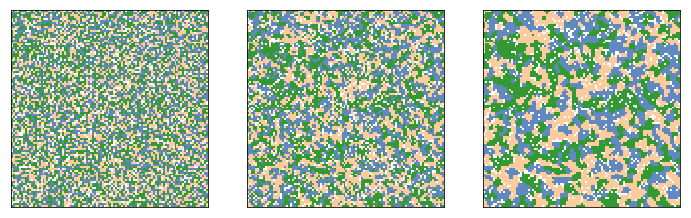

In [32]:
RandomSeed(17)

grid = Schelling(n=100, p=0.3)
print(grid.segregation())

thinkplot.preplot(cols=3)
viewer = SchellingViewer(grid)
viewer.draw()

thinkplot.subplot(2)
for i in range(2):
    viewer.step()
print(grid.segregation())
viewer.draw()

thinkplot.subplot(3)
for i in range(8):
    viewer.step()
print(grid.segregation())
viewer.draw()

plt.savefig('chap09-1.pdf')

And here's how segregation in steady state relates to `p`, the threshold on the fraction of similar neighbors.

0.5 0.873926663274 0.373926663274
0.4 0.826708097688 0.426708097688
0.3 0.733743792479 0.433743792479
0.2 0.546853167133 0.346853167133


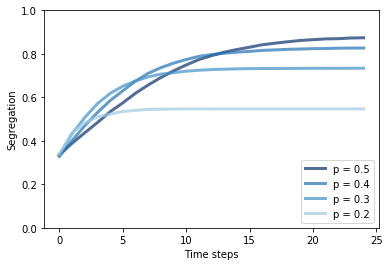

In [33]:
RandomSeed(17)

for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(25)]
    thinkplot.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
thinkplot.config(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

plt.savefig('chap09-2.pdf')

At `p=0.3`, there is a striking difference between the level that would make people happy, at only 30%, and the level they actually get, around 75%.

**Exercise:** Experiment with different starting conditions: for example, more or fewer empty cells, or unequal numbers of red and blue agents.

## Sugarscape

`make_locs` takes the dimensions of the grid and returns an array where each row is a coordinate in the grid.

In [34]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    left = np.repeat(np.arange(m), n)
    right = np.tile(np.arange(n), m)
    return np.transpose([left, right])

In [35]:
make_locs(2, 3)

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [2, 0],
       [2, 1]])

`make_visible_locs` takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.

The cells are at increasing distances.  The cells at each distance are shuffled. 

In [36]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [37]:
make_visible_locs(2)

array([[ 0, -1],
       [-1,  0],
       [ 1,  0],
       [ 0,  1],
       [ 2,  0],
       [-2,  0],
       [ 0, -2],
       [ 0,  2]])

Here's my implementation of Sugarscape:

In [38]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        x = np.arange(self.n)
        rows, cols = np.meshgrid(x, x, indexing='ij')
        
        # each cell in `rows` contains its own `i` coordinate
        # each cell in `cols` contains its `j` coordinate
        dist1 = np.hypot(rows-15, cols-15)
        dist2 = np.hypot(rows-35, cols-35)
        
        # each cell in `dist` contains its distance to the closer peak
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        a = np.zeros((self.n, self.n), np.float)
        a[dist<21] = 1
        a[dist<16] = 2
        a[dist<11] = 3
        a[dist<6] = 4

        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_around(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

And here's a viewer that displays the state of Sugarscape.

In [39]:
class SugarscapeViewer(Cell2DViewer):
    """Generates visualization and animation of Sugarscape."""
    
    cmap = plt.get_cmap('YlOrRd')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Here's my implementation of the agents.

In [40]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_around(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

Here's an example with `n=50`, starting with 400 agents.

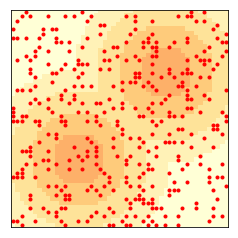

In [41]:
env = Sugarscape(50, num_agents=400)
viewer = SugarscapeViewer(env)
viewer.draw()

The distribution of vision is uniform from 1 to 6.

{'xscale': 'linear', 'yscale': 'linear'}

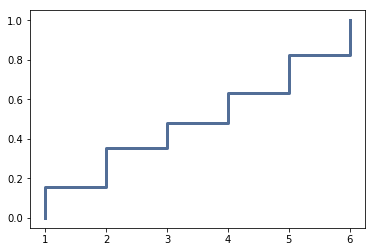

In [42]:
cdf = Cdf(agent.vision for agent in env.agents)
thinkplot.Cdf(cdf)

The distribution of metabolism is uniform from 1 to 4.

{'xscale': 'linear', 'yscale': 'linear'}

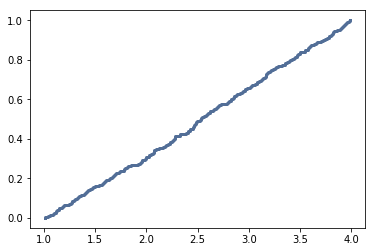

In [43]:
cdf = Cdf(agent.metabolism for agent in env.agents)
thinkplot.Cdf(cdf)

The distribution of initial endowment of sugar is uniform from 5 to 25.

{'xscale': 'linear', 'yscale': 'linear'}

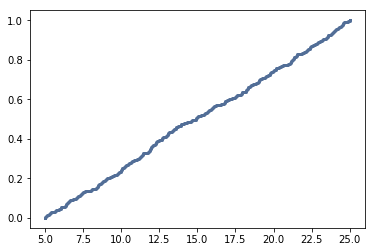

In [44]:
cdf = Cdf(agent.sugar for agent in env.agents)
thinkplot.Cdf(cdf)

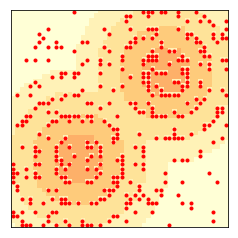

In [45]:
env.step()
viewer = SugarscapeViewer(env)
viewer.draw()

Here's what the animation looks like.

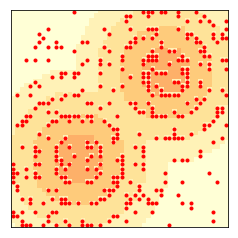

In [46]:
anim = viewer.animate(frames=500)

In [47]:
anim

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


The number of agents levels off at the "carrying capacity":

In [48]:
len(env.agents)

232

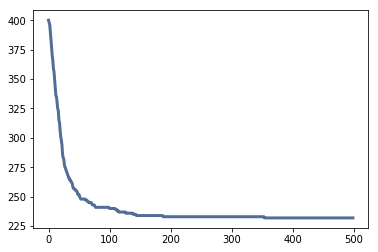

In [49]:
thinkplot.plot(env.agent_count_seq)

This figure shows the state of the system after 2 and 10 steps.

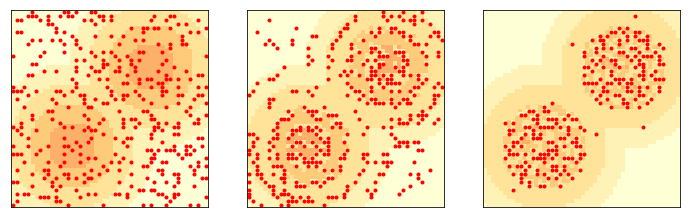

In [50]:
RandomSeed(17)

env = Sugarscape(50, num_agents=400)
viewer = SugarscapeViewer(env)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(2):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(98):
    viewer.step()
viewer.draw()

plt.savefig('chap09-3.pdf')

**Exercise:** Experiment with different numbers of agents.  Try increasing or decreasing their vision or metabolism, and see what effect is has on carrying capacity.

## Sugarscape with finite lifespans

Now we start with 250 agents, with lifetimes from 60 to 100, and replacement.

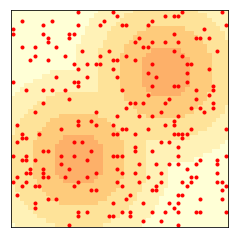

In [51]:
env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=100)

Here's what the animation looks like:

In [52]:
anim

After 100 time steps, the distribution of wealth is skewed to the right.  Most agents have very little sugar, but a few have a lot.

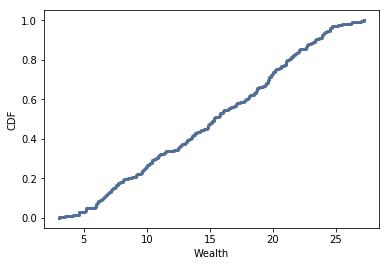

In [31]:
cdf = Cdf(agent.sugar for agent in env.agents)
thinkplot.Cdf(cdf)
thinkplot.config(xlabel='Wealth', ylabel='CDF')

In [32]:
cdf.Percentiles([25, 50, 75, 90])

array([  9.86056551,  15.35308279,  20.22600927,  23.32097059])

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [33]:
RandomSeed(17)

env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

cdfs = []
for i in range(5):
    [env.step() for i in range(100)]
    cdf = Cdf(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

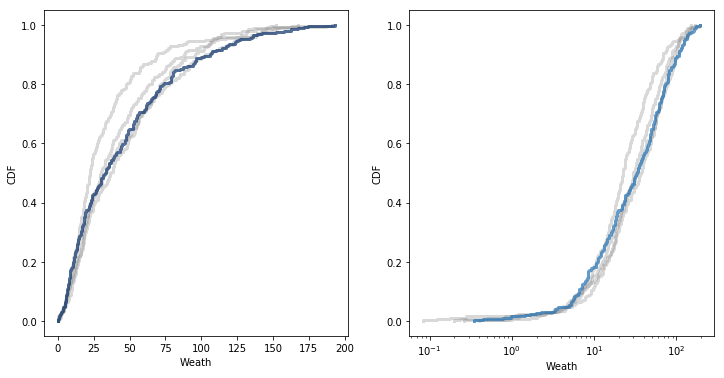

In [34]:
thinkplot.preplot(cols=2)

thinkplot.Cdfs(cdfs[:-1], color='gray', alpha=0.3)
thinkplot.Cdf(cdfs[-1])
thinkplot.config(xlabel='Weath', ylabel='CDF')

thinkplot.subplot(2)
thinkplot.Cdfs(cdfs[:-1], color='gray', alpha=0.3)
thinkplot.Cdf(cdfs[-1])
thinkplot.config(xlabel='Weath', ylabel='CDF', xscale='log')

plt.savefig('chap09-4.pdf')

**Exercise:** Experiment with different starting conditions and agents with different vision, metabolism, and lifespan.  What effect do these changes have on the distribution of wealth?

## Migration in waves

If we start with all agents in the lower left, they propagate up and to the right in waves.

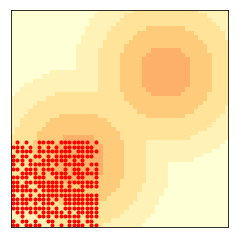

In [35]:
RandomSeed(17)

env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
    
viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=20, interval=500)

In [36]:
anim

ValueError: Invalid file object: <_io.BufferedReader name=69>

Here's what it looks like after 6 and 12 steps.

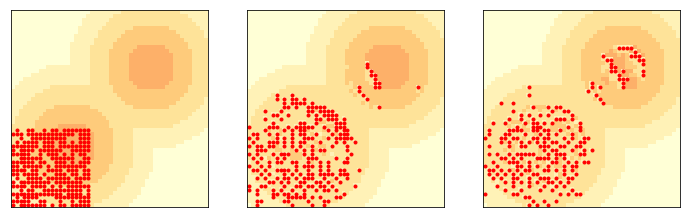

In [37]:
env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
viewer = SugarscapeViewer(env)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(6):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(6):
    viewer.step()
viewer.draw()

plt.savefig('chap09-5.pdf')

This example is interesting because the waves move diagonally, unlike the agents, who can only move up or to the right.  They are similar in some ways to gliders and other Game of Life spaceships. 

**Exercise:** Again, experiment with different starting conditions and see what effect they have on the wave behavior.

## Exercises

**Exercise:** Bill Bishop, author of *The Big Sort*, argues that
American society is increasingly segregated by political
opinion, as people choose to live among like-minded neighbors.

The mechanism Bishop hypothesizes is not that people, like the agents
in Schelling's model, are more likely to move if they are
isolated, but that when they move for any reason, they are
likely to choose a neighborhood with people like themselves.

Write a version of Schelling's model to simulate
this kind of behavior and see if it yields similar degrees of
segregation.

There are several ways you can model Bishop's hypothesis.  In my
implementation, a random selection of agents moves during each step.
Each agent considers `k` randomly-chosen empty locations and
chooses the one with the highest fraction of similar neighbors.
How does the degree of segregation depend on `k`?

You should be able to implement this model by inheriting from
`Schelling` and overriding `__init__` and `step`.



In [38]:
# Solution goes here

In [39]:
# Solution goes here

And a test of the `step` method

In [40]:
# Solution goes here

In [41]:
# Solution goes here

In [42]:
# Solution goes here

In [43]:
# Solution goes here

In [44]:
# Solution goes here

**Exercise:** In the first version of Sugarscape, we never add agents, so once the population falls, it never recovers.  In the second version, we only replace agents when they die, so the population is constant.  Now let's see what happens if we add some "population pressure".

Write a version of Sugarscape that adds a new agent at the end of every step.  Add code to compute the average vision and the average metabolism of the agents at the end of each step.  Run the model for a few hundred steps and plot the population over time, as well as the average vision and average metabolism.

You should be able to implement this model by inheriting from
`Sugarscape` and overriding `__init__` and `step`.

In [45]:
# Solution goes here

In [46]:
# Solution goes here

In [47]:
# Solution goes here

In [48]:
# Solution goes here

In [49]:
# Solution goes here

In [50]:
# Solution goes here

In [51]:
# Solution goes here

In [52]:
# Solution goes here

In [53]:
# Solution goes here

In [54]:
# Solution goes here